In [1077]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [1078]:
df_full = pd.read_csv('data_thomas.csv', index_col="date", parse_dates=["date"])
df_full.dropna(inplace=True)
df = df_full[:4000]
df_eval = df_full[4001:]

In [1079]:
df.sort_index(axis=0, ascending=True, inplace=True)


In [1080]:
x = df.drop(['1. open', '2. high', '3. low', '5. adjusted close', '7. dividend amount', '8. split coefficient',
             'shifted_ROC_BOOL'], axis=1).copy()

x.head()

,4. close,6. volume,roc,sma,ema,rsi,obv,MACD_Signal,MACD,MACD_Hist,SlowK,SlowD,adx,cci,Aroon Up,Aroon Down,Real Lower Band,Real Middle Band,Real Upper Band,ad
date,,,,,,,,,,,,,,,,,,,,
1999-12-28,28.75,780300.0,-0.6565,14.6350,14.2512,58.0771,43062400.0,0.7219,0.4981,-0.2239,27.4304,35.4404,43.5091,-48.0229,35.0,60.0,13.4313,14.6350,15.8387,6.374274e+07
1999-12-29,28.44,522600.0,-1.0783,14.6398,14.2483,57.0397,42017200.0,0.6661,0.4426,-0.2235,28.5393,29.0019,42.3421,-69.9336,30.0,55.0,13.4434,14.6398,15.8361,6.383307e+07
1999-12-30,28.44,892400.0,0.0000,14.6633,14.2456,57.0397,42017200.0,0.6117,0.3941,-0.2176,30.6254,28.8651,41.1439,-82.6652,25.0,50.0,13.5204,14.6633,15.8061,6.444066e+07
1999-12-31,28.94,882800.0,1.7581,14.6243,14.2670,58.3687,43782800.0,0.5636,0.3716,-0.1921,52.7724,37.3124,40.0687,-52.8434,20.0,45.0,13.5113,14.6243,15.7372,6.620626e+07
2000-01-03,31.00,3921600.0,7.1182,14.6243,14.3844,63.2931,51626000.0,0.5373,0.4318,-0.1055,77.1122,53.5034,39.6958,113.0544,15.0,40.0,13.5113,14.6243,15.7372,7.240282e+07


In [1081]:
y = df['shifted_ROC_BOOL'].copy()
y.head()

date
1999-12-28    0
1999-12-29    1
1999-12-30    1
1999-12-31    1
2000-01-03    0
Name: shifted_ROC_BOOL, dtype: int64

In [1082]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [1083]:
x_eval = df_eval.drop(
    ['1. open', '2. high', '3. low', '5. adjusted close', '7. dividend amount', '8. split coefficient',
     'shifted_ROC_BOOL'], axis=1).copy()
y_eval = df_eval['shifted_ROC_BOOL'].copy()

eval_set = [(xgb.DMatrix(x_eval, label=y_eval), 'eval')]

In [1084]:
train = xgb.DMatrix(x_train, label=y_train)
test = xgb.DMatrix(x_test, label=y_test)
param = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:hinge',
    'gamma': 0.1,
    'subsample': 0.33,
    'eval_metric': 'error' # Binary classification error rate 
}
epochs = 10

In [1085]:
model = xgb.train(params=param, dtrain=train, num_boost_round=epochs, evals=eval_set, early_stopping_rounds=5)

[0]	eval-error:0.46465
[1]	eval-error:0.46465
[2]	eval-error:0.46465
[3]	eval-error:0.45960
[4]	eval-error:0.47330
[5]	eval-error:0.46970
[6]	eval-error:0.46248
[7]	eval-error:0.46392


In [1086]:
predictions_in_sample = model.predict(train)
predictions = model.predict(test)

In [1087]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_out = accuracy_score(y_test, predictions)
accuracy_in = accuracy_score(y_train, predictions_in_sample)

precision_out = precision_score(y_test, predictions)
precision_in = precision_score(y_train, predictions_in_sample)

recall_out = recall_score(y_test, predictions)
recall_in = recall_score(y_train, predictions_in_sample)

f_score_out = f1_score(y_test, predictions)
f_score_in = f1_score(y_train, predictions_in_sample)

print(f"Accuracy out-of-sample: {accuracy_out}")
print(f"Precision out-of-sample: {precision_out}")
print(f"Recall out-of-sample: {recall_out}")
print(f"FScore out-of-sample: {f_score_out}\n")

print(f"Accuracy in-sample: {accuracy_in}")
print(f"Precision in-sample: {precision_in}")
print(f"Recall in-sample: {recall_in}")
print(f"FScore in-sample: {f_score_in}")


Accuracy out-of-sample: 0.52875
Precision out-of-sample: 0.5354330708661418
Recall out-of-sample: 0.9466357308584686
FScore out-of-sample: 0.6839899413243924

Accuracy in-sample: 0.61625
Precision in-sample: 0.5762253956001544
Recall in-sample: 0.9199014171287738
FScore in-sample: 0.7085904129093499


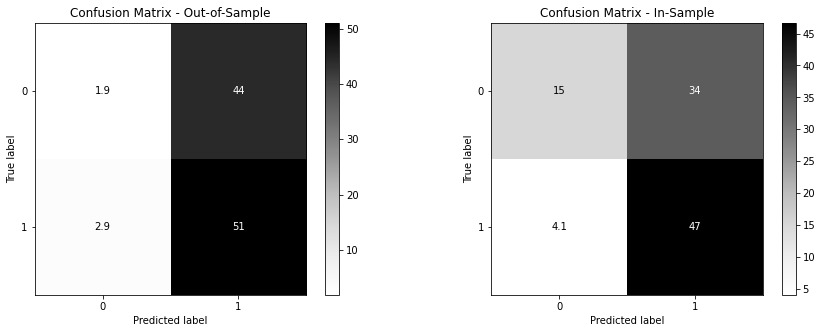

In [1088]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cm_out = confusion_matrix(y_test, predictions) / len(y_test) * 100
cm_in = confusion_matrix(y_train, predictions_in_sample) / len(y_train) * 100

ax[0].set_title("Confusion Matrix - Out-of-Sample")
ax[1].set_title("Confusion Matrix - In-Sample")

ax[0] = ConfusionMatrixDisplay(confusion_matrix=cm_out).plot(ax=ax[0], cmap='Greys')
ax[1] = ConfusionMatrixDisplay(confusion_matrix=cm_in).plot(ax=ax[1], cmap='Greys')

plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

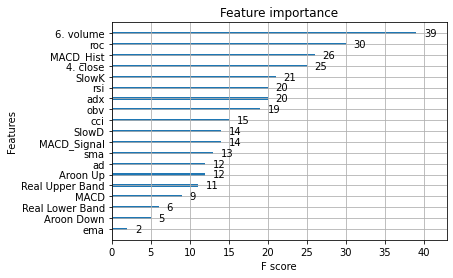

In [1089]:
xgb.plot_importance(model)
